## Week 9 Notebook

For this week, include ideas such as gradient boost, learning rate, number of estimators, tree depth, and regularization. This homework should be submitted for peer review in the assignment titled 9.3 Peer Review: Week 9 Jupyter Notebook. Complete and submit your Jupyter Notebook homework by 11:59pm ET on Sunday. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import feature engineering and selection libraries
from sklearn.ensemble import GradientBoostingClassifier

# data preprocesing
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Classification metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, classification_report

random_state = 0

In [2]:
def encoding(df_or_series, cat_cols: list = None, one_hot: bool = False):
    """
    Encodes categorical columns in a DataFrame or a single pandas Series.

    Args:
        df_or_series: DataFrame or Series to encode.
        cat_cols: List of columns to encode (only used if input is DataFrame).
        one_hot: If True, use one-hot encoding for DataFrame input.

    Returns:
        If input is DataFrame: (encoded DataFrame, mappings dict or list of new columns)
        If input is Series: (encoded Series, mapping dict)
    """
    if isinstance(df_or_series, pd.Series):
        uniques = df_or_series.dropna().unique().tolist()
        mapping = {cat: code for code, cat in enumerate(uniques)}
        encoded = df_or_series.map(mapping).astype("int64")
        return encoded, mapping
    
    elif isinstance(df_or_series, pd.DataFrame):
        if one_hot:
            if cat_cols is None:
                cat_cols = df_or_series.select_dtypes(include=['object', 'category']).columns.tolist()
            df_encoded = pd.get_dummies(df_or_series, columns=cat_cols, drop_first=True)
            new_cols = [col for col in df_encoded.columns if col not in df_or_series.columns or col in cat_cols]
            return df_encoded, new_cols
        else:
            df_encoded = df_or_series.copy()
            mappings = {}
            if cat_cols is None:
                cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
            for col in cat_cols:
                uniques = df_encoded[col].dropna().unique().tolist()
                mapping = {cat: code for code, cat in enumerate(uniques)}
                mappings[col] = mapping
                df_encoded[col] = df_encoded[col].map(mapping).astype("int64")
            return df_encoded, mappings
    
    else:
        raise ValueError("Input must be a pandas DataFrame or Series.")

In [3]:
def load_and_split_data(file_path: str, target_col: str = None, one_hot: bool = False, test_size: float = 0.2, random_state: int = 0, scaling: str = 'norm'):
    """
    Loads data, encodes categorical features, splits into train/test, and scales features.

    Args:
        file_path: Path to CSV file.
        target_col: Name of target column. If None, uses last column.
        test_size: Fraction for test split.
        random_state: Random seed.
        scaling: 'norm' (MinMax), 'reg' (Standard), or None.

    Returns:
        X_train, X_test, y_train, y_test, df, mappings
    """
    df = pd.read_csv(file_path)
    
    # Select target
    if target_col is None:
        target_col = df.columns[-1]
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Encode Categorical Features
    if one_hot is True:
        X_encoded, new_cols = encoding(X, one_hot=True)
        y_encoded, mappings = encoding(y)
    else:
        X_encoded, mappings = encoding(X)
        y_encoded, mappings = encoding(y)
        

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y_encoded, test_size=test_size, random_state=random_state
    )

    # Reset indices
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Scaling
    if scaling == 'reg':
        scaler = StandardScaler()
    elif scaling == 'norm':
        scaler = MinMaxScaler()
    else:
        scaler = None

    if scaler is not None:
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    return X_train, X_test, y_train, y_test, df, mappings


In [4]:
# Load the ins claims dataset with variations of encoding and scaling
X_train_ins_oh, X_test_ins_oh, y_train_ins_oh, y_test_ins_oh, df_ins_oh, ins_oh_mappings = load_and_split_data(
    r'C:\Users\JT von Seggern\DS Masters Repos\2025-spring-B2\data\insurance_claims_cleaned.csv', 
    target_col='fraud_reported', one_hot=True, scaling='reg')

X_train_ins_en, X_test_ins_en, y_train_ins_en, y_test_ins_en, df_ins_en, ins_en_mappings = load_and_split_data(
    r'C:\Users\JT von Seggern\DS Masters Repos\2025-spring-B2\data\insurance_claims_cleaned.csv', 
    target_col='fraud_reported', one_hot=False, scaling='reg')

X_train_ins, X_test_ins, y_train_ins, y_test_ins, df_ins, ins_mappings = load_and_split_data(
    r'C:\Users\JT von Seggern\DS Masters Repos\2025-spring-B2\data\insurance_claims_cleaned.csv', 
    target_col='fraud_reported', one_hot=False, scaling=None)

In [5]:
def gridsearchcv(model, X_train, y_train, param_dict=None, random_state=random_state, scoring='accuracy', cv=None):
    """
    Generic grid search function for any sklearn model and parameter grid.

    Args:
        model: The sklearn model class (not an instance), e.g., SVC, RandomForestClassifier, etc.
        X_train: Training features.
        y_train: Training target.
        param_dict: Dictionary of parameter grid for the model.
        random_state: Random state for reproducibility.
        scoring: Scoring metric for GridSearchCV.
        cv: Cross-validation strategy (optional).

    Returns:
        grid_best_params: Best parameter dictionary.
        grid_cv_score: Best cross-validated score.
    """
    # If the model supports random_state, pass it; otherwise, ignore
    try:
        base_model = model(random_state=random_state)
    except TypeError:
        base_model = model()

    # Use provided cv or default to RepeatedStratifiedKFold for classification
    if cv is None:
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=random_state)

    search = GridSearchCV(
        estimator=base_model,
        param_grid=param_dict,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        return_train_score=True,
        error_score='raise'
    )

    search.fit(X_train, y_train)

    # Extract results into a DataFrame
    results = pd.DataFrame(search.cv_results_)

    # Print top 5 results (show all param columns dynamically)
    param_cols = [col for col in results.columns if col.startswith('param_')]
    display_cols = param_cols + [
        'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'rank_test_score'
    ]
    results = results[display_cols].sort_values(by='rank_test_score')
    renamed_results = results.rename(
        columns={col: col.replace('param_', '') for col in param_cols} |
                {'mean_test_score': 'mean_cv_score', 'std_test_score': 'std_cv_score'}
    ).drop(columns=['rank_test_score'])

    print("\nSearch Results (Top 5):\n")
    print(renamed_results.head(5).to_string(index=False))

    # Best parameters and test performance
    grid_best_params = search.best_params_
    print(f"\nBest Parameters: {grid_best_params}")
    grid_cv_score = search.best_score_
    print(f"Best CV Score: {grid_cv_score:.4f}")

    return grid_best_params, grid_cv_score

In [11]:
def classifier_model(data_used, model_class, X_train, y_train, X_test, y_test, **model_params):
    """
    Generic function to fit and evaluate any sklearn classifier model.

    Args:
        data_used: String indicating the dataset used (for logging purposes).
        model_class: The sklearn classifier class (e.g., RandomForestClassifier, DecisionTreeClassifier).
        X_train, y_train: Training data.
        X_test, y_test: Test data.
        model_params: Parameters for the classifier.

    Prints:
        Classification report, accuracy, F1 score, and confusion matrix plot.

    Returns:
        model: The fitted model.
        y_pred: The predictions on X_test.
        results: Dictionary of results for later analysis.
    """
    model = model_class(**model_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    clf_name = model_class.__name__

    # Print the classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    print(f"Classification Report for {clf_name} with {data_used}:")
    print(classification_report(y_test, y_pred, output_dict=False))
    print("\n")

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{clf_name} Accuracy: {accuracy:.2f}")
    
    # Calculate f1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{clf_name} F1 score: {f1:.2f}")
    
    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {clf_name} with {data_used}')
    plt.tight_layout()
    plt.show()

    # Save results for later analysis
    results = {
        'data_used': data_used,
        'model_name': clf_name,
        'model_params': model.get_params(),
        'accuracy': accuracy,
        'f1_score': f1,
        'classification_report': report,
        'confusion_matrix': cm,
        'y_true': y_test,
        'y_pred': y_pred
    }

    return model, y_pred, results

In [7]:
# Run Gridsearch on the insurance claims dataset with one-hot encoding
ins_oh_param_grid = {
    'learning_rate': [.01, .05, .1, .2, .3],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3,5,7,9,11]
}

grid_best_params_ins_oh, grid_cv_score_ins_oh = gridsearchcv(
    GradientBoostingClassifier, X_train_ins_oh, y_train_ins_oh, param_dict=ins_oh_param_grid, random_state=random_state, scoring='accuracy', cv=5)


Search Results (Top 5):

 learning_rate  max_depth  n_estimators  mean_cv_score  std_cv_score  mean_train_score  std_train_score
          0.01         11           300        0.83125      0.007906          1.000000         0.000000
          0.01          9           200        0.83125      0.016298          0.998750         0.001169
          0.10          7           200        0.83125      0.015811          1.000000         0.000000
          0.05          5           100        0.83000      0.016489          0.993437         0.003878
          0.20          7           100        0.82875      0.016583          1.000000         0.000000

Best Parameters: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200}
Best CV Score: 0.8313


In [8]:
# Run Gridsearch on the insurance claims dataset with one-hot encoding
ins_en_param_grid = {
    'learning_rate': [.01, .05, .1, .2, .3],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3,5,7,9,11]
}

grid_best_params_ins_en, grid_cv_score_ins_en = gridsearchcv(
    GradientBoostingClassifier, X_train_ins_en, y_train_ins_en, param_dict=ins_en_param_grid, random_state=random_state, scoring='accuracy', cv=5)


Search Results (Top 5):

 learning_rate  max_depth  n_estimators  mean_cv_score  std_cv_score  mean_train_score  std_train_score
          0.10          7           300        0.84250      0.010753          1.000000         0.000000
          0.20          5           200        0.84250      0.008292          1.000000         0.000000
          0.20          7           400        0.84125      0.012870          1.000000         0.000000
          0.01          5           300        0.84125      0.010155          0.989062         0.002795
          0.20          7           200        0.84125      0.012870          1.000000         0.000000

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Best CV Score: 0.8425


In [ ]:
# Run Gridsearch on the insurance claims dataset with one-hot encoding
ins_param_grid = {
    'learning_rate': [.01, .05, .1, .2, .3],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3,5,7,9,11] 
}

grid_best_params_ins, grid_cv_score_ins = gridsearchcv(
    GradientBoostingClassifier, X_train_ins, y_train_ins, param_dict=ins_param_grid, random_state=random_state, scoring='accuracy', cv=5)


Search Results (Top 5):

 learning_rate  max_depth  n_estimators  mean_cv_score  std_cv_score  mean_train_score  std_train_score
          0.20          5           200        0.84250      0.008292          1.000000         0.000000
          0.01          5           300        0.84125      0.010155          0.989062         0.002795
          0.20          7           400        0.84125      0.012870          1.000000         0.000000
          0.10          7           300        0.84125      0.009354          1.000000         0.000000
          0.20          7           200        0.84125      0.012870          1.000000         0.000000

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Best CV Score: 0.8425


Classification Report for GradientBoostingClassifier with one-hot encoded insurance claims dataset:
              precision    recall  f1-score   support

           0       0.72      0.49      0.58        57
           1       0.82      0.92      0.87       143

    accuracy                           0.80       200
   macro avg       0.77      0.71      0.73       200
weighted avg       0.79      0.80      0.79       200



GradientBoostingClassifier Accuracy: 0.80
GradientBoostingClassifier F1 score: 0.79


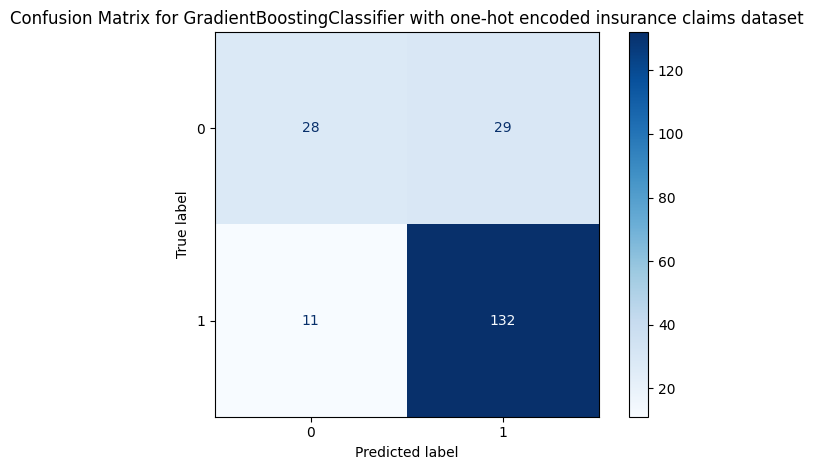

Classification Report for GradientBoostingClassifier with encoded insurance claims dataset:
              precision    recall  f1-score   support

           0       0.64      0.47      0.55        57
           1       0.81      0.90      0.85       143

    accuracy                           0.78       200
   macro avg       0.73      0.68      0.70       200
weighted avg       0.76      0.78      0.76       200



GradientBoostingClassifier Accuracy: 0.78
GradientBoostingClassifier F1 score: 0.76


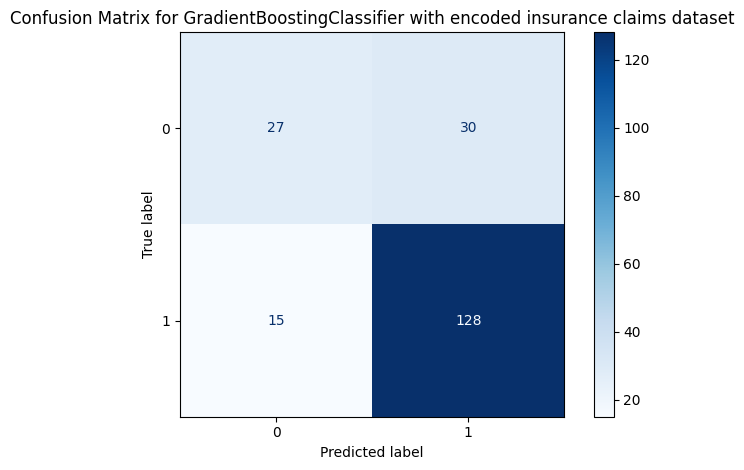

Classification Report for GradientBoostingClassifier with no Scaling or Encoding insurance claims dataset:
              precision    recall  f1-score   support

           0       0.65      0.46      0.54        57
           1       0.81      0.90      0.85       143

    accuracy                           0.78       200
   macro avg       0.73      0.68      0.69       200
weighted avg       0.76      0.78      0.76       200



GradientBoostingClassifier Accuracy: 0.78
GradientBoostingClassifier F1 score: 0.76


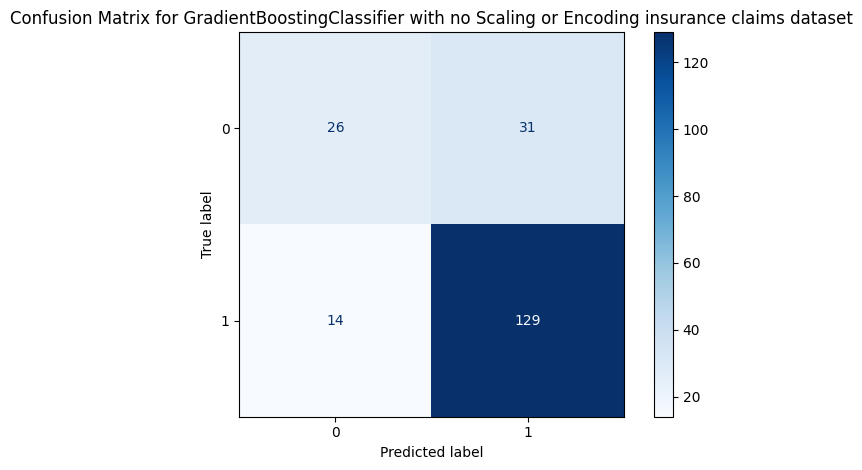

In [13]:
# Run a baseline version of Gradient Boosting on the insurance claims dataset with one-hot encoding and without
base_ins_oh_model, base_ins_oh_pred, base_ins_oh_results = classifier_model(
    "one-hot encoded insurance claims dataset",
    GradientBoostingClassifier,
    X_train_ins_oh,
    y_train_ins_oh,
    X_test_ins_oh,
    y_test_ins_oh
)

base_ins_en_model, base_ins_en_pred, base_ins_en_results = classifier_model(
    "encoded insurance claims dataset",
    GradientBoostingClassifier, 
    X_train_ins_en, 
    y_train_ins_en, 
    X_test_ins_en, 
    y_test_ins_en
)

# Run the classifier model bunction with the best parameters from gridsearch
grid_ins_model, grid_ins_pred, grid_ins_results = classifier_model(
    "no Scaling or Encoding insurance claims dataset",
    GradientBoostingClassifier, 
    X_train_ins, 
    y_train_ins, 
    X_test_ins, 
    y_test_ins, 
    **grid_best_params_ins
)
